# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Empirical Pipeline for Fictitious Prediction </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;"> 
In this notebook, I analyze crap.
</p>


# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Table of Contents </strong> </p>


<table style="margin-left: auto; margin-right: auto; width: 85%; border-collapse: collapse; font-family: 'Georgia', serif; font-size: 105%; border: 2px solid #333;">
    <tr>
        <td>No</td>
        <td>Contents</td>
        <td>No</td>
        <td>Contents</td>
    </tr>
    <tr>
        <td>1</td>
        <td><a href="#1"> FILL IN </a></td>
        <td>6</td>
        <td><a href="#6"> FILL IN</a></td>
    </tr>
    <tr>
        <td>2</td>
        <td><a href="#2">Data Description</a></td>
        <td>7</td>
        <td><a href="#7">Investigating Prime Mod 4</a></td>
    </tr>
    <tr>
        <td>3</td>
        <td><a href="#3"> Data Setup</a></td>
        <td>8</td>
        <td><a href="#8">Difference List Analysis</a></td>
    </tr>
    <tr>
        <td>4</td>
        <td><a href="#4"> Diff Plot Examples</a></td>
        <td>9</td>
        <td><a href="#9">Conclusion</a></td>
    </tr>
    <tr>
        <td>5</td>
        <td><a href="#5">Basic EDA</a></td>
        <td></td> 
    </tr>
</table>


In [2]:
import os 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
SRC_PATH      = os.getcwd()
MAIN_PATH     = os.path.dirname(SRC_PATH)               
DATA_PATH     = f"{MAIN_PATH}/data"
CSV_FPATH     = f'{DATA_PATH}/results.csv'
PLOT_PATH     = f'{DATA_PATH}/plots'
PMETA_FPATH   = f'{DATA_PATH}/plot_metadata.json'
SEED          = 10

In [4]:
df = pd.read_csv(CSV_FPATH)
df.head()

,id,pop_size,lex_size,vocab_size,epsilon,speech_len,alpha,beta,a_mult,strength,num_folds,model,param_grid,scoring,rho,score
0,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.759870,0.301800
1,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.813851,0.186761
2,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.735409,0.344146
3,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.680085,0.457442
4,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.711060,0.344835


In [5]:
def plot(dataframe, x='rho', y='score', title=None, savefig=False, plot_desc=None):
    df = dataframe.copy()
    if df['id'].nunique() != 1:
        raise ValueError("All 'id' values must be the same in the dataframe.")

    scoring_map = {"accuracy": "Accuracy", "neg_log_loss": "Log Likelihood", "f1": "F1 Score"}

    scoring_name = scoring_map.get(df['scoring'].iloc[0], df['scoring'].iloc[0])
    y_label = scoring_name
    x_label = "Polarization"

    plot_title = title if title else f"{y_label} vs. {x_label}"
    plt.figure(figsize=(12,8))
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    if y_label == 'Log Likelihood':
        df['score'] = df['score'].apply(lambda x : -x) # flip score
        
    ax = sns.scatterplot(x=x, y=y, data=df)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(plot_title)

    if savefig:
        PLOT_PATH = os.path.join(os.getcwd(), 'plots')
        os.makedirs(PLOT_PATH, exist_ok=True)
        plot_file_path = os.path.join(PLOT_PATH, f"{plot_title}.jpg")
        plt.savefig(plot_file_path)

        # If plot description is provided, save it to metadata
        if plot_desc is not None:
            metadata = {}
            if os.path.exists(PMETA_FPATH):
                with open(PMETA_FPATH, 'r') as file:
                    metadata = json.load(file)
            metadata[plot_file_path] = plot_desc
            with open(PMETA_FPATH, 'w') as file:
                json.dump(metadata, file, indent=4)

    # 5) Create a box with other parameters
    other_params = df.drop(['rho', 'score'], axis=1).iloc[0].to_dict()
    textstr = '\n'.join([f"{key} = {val}" for key, val in other_params.items()])
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.show()

/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 1200x800 with 0 Axes>

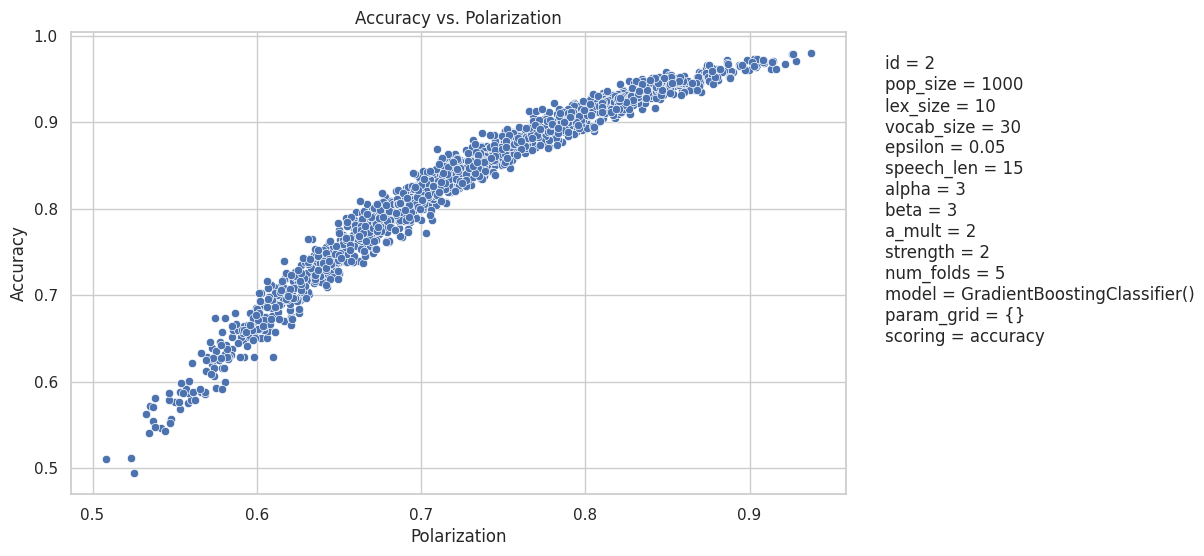

In [7]:
acc = df[df['id'] == 2]
bce = df[df['id'] == 1]
bce_large = df[df['id'] == 4]

plot(acc)

/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 1200x800 with 0 Axes>

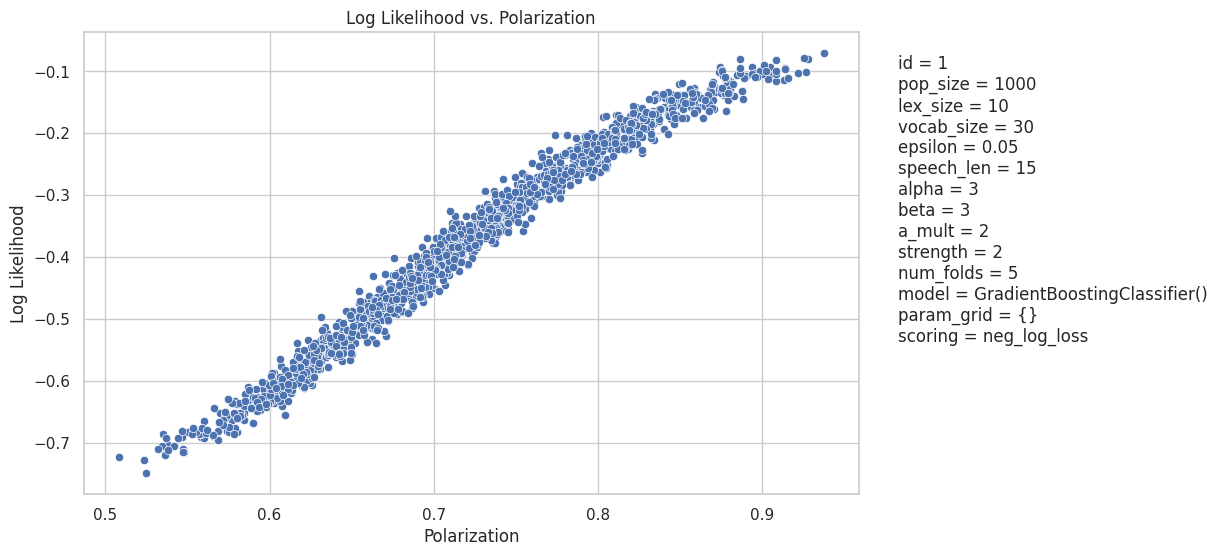

In [8]:
plot(bce)

/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bizon/anaconda3/envs/jhc5/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 1200x800 with 0 Axes>

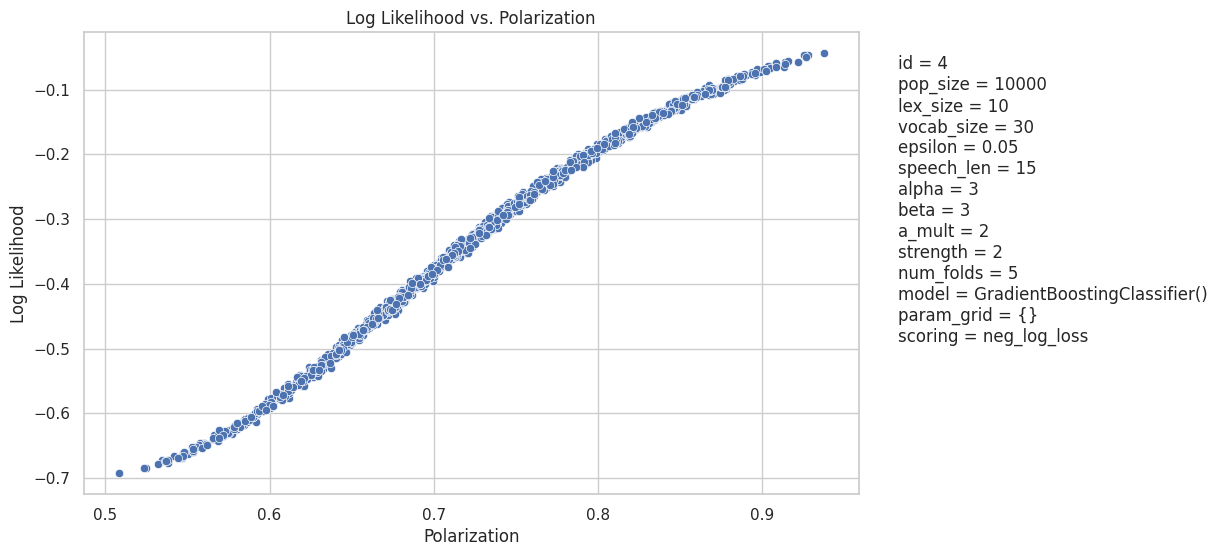

In [9]:
plot(bce_large)